# Darstellung von Radrouten in einer Stadt

In [44]:
import osmnx as ox
import networkx as nx
import numpy as np
from tqdm import tqdm
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
ox.__version__
ox.settings.log_console=True
np.random.seed(0)

## Netzwerkgraphen erzeugen

In [2]:
# modify the place name and desired network types
place = "Dortmund, Germany"
place_short = "Dortmund"

G_BIKE = ox.graph_from_place(place, network_type="bike")
# project the graph for further use
G_BIKE_p = ox.project_graph(G_BIKE)

## Start- und Zielorte festlegen

In [ ]:
start_pt_name = "Borsigplatz, Dortmund"
origin_pt_lat_lon = ox.geocoder.geocode(start_pt_name)

origin_node = ox.nearest_nodes(G_BIKE, origin_pt_lat_lon[1], origin_pt_lat_lon[0])

sample_pts = ox.utils_geo.sample_points(ox.get_undirected(G_BIKE), n=100)
X = sample_pts.x.values
Y = sample_pts.y.values
destination_nodes = ox.nearest_nodes(G_BIKE, X, Y)

### Routing

#### Vorbereitung des Netzwerks

In [83]:
# impute speed on all edges missing data
G_BIKE = ox.add_edge_speeds(G_BIKE)

# add max speed to edges
hwy_speeds = {"residential": 20, "tertiary": 23, "primary" : 26, "secondary": 26}
G_BIKE = ox.add_edge_speeds(G_BIKE, hwy_speeds, fallback=19)

# cap the max speed to 26 km/h
nodes, edges = ox.graph_to_gdfs(G_BIKE)
edges["speed_kph"].clip(0, 26, inplace=True)
G_BIKE = ox.graph_from_gdfs(nodes, edges)

# calculate travel time (seconds) for all edges
G_BIKE = ox.add_edge_travel_times(G_BIKE)

#### Routenberechnung vom Startpunkt zu jedem Zielort

In [85]:
routes = []
for dest_node in tqdm(destination_nodes):
    route1 = ox.shortest_path(G_BIKE, origin_node, dest_node, weight="length")
    route2 = ox.shortest_path(G_BIKE, origin_node, dest_node, weight="travel_time")
    
    route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_BIKE, route1, "length")))
    route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_BIKE, route1, "travel_time")))
    route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_BIKE, route2, "length")))
    route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_BIKE, route2, "travel_time")))
    speed_1 = route1_length / route1_time
    speed_2 = route2_length / route2_time
    
    routes.append((route1, speed_1))
    routes.append((route2, speed_2))

100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


### Darstellung als Graph

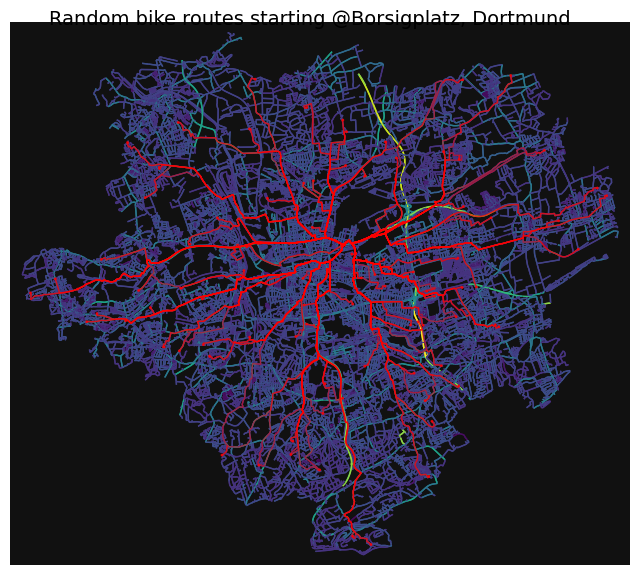

In [88]:
outpath = f'./output_data/images/{place_short}_bike_routes.png'

ec = ox.plot.get_edge_colors_by_attr(G_BIKE, 'speed_kph', cmap='viridis', num_bins=20)
routes_list = [route[0] for route in routes]
routes_avg_speeds = [route[1] for route in routes]

# TODO add route_avg_speed as route color, relative to the max speed of all routes

fig, ax = ox.plot_graph_routes(G_BIKE, routes = routes_list, route_linewidths = 1, orig_dest_size = 4,
                                edge_color=ec, edge_linewidth=1, node_size = 0,
                                close=False, show=False)
  
# set title, adjust y position
fig.suptitle(f'Random bike routes starting @{start_pt_name}', fontsize=14, y=0.85)

fig.savefig(outpath, dpi=1200, bbox_inches='tight')